In [1]:
import pandas as pd

import re
import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from models import TemporalFusionTransformer

import warnings

In [2]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emrekuru/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# EDA and Processing

## Tweets

In [3]:
tweets_df = pd.read_csv("datasets/tweets.csv")
tweets_df.head(5)

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


25


<Axes: xlabel='Stock Name'>

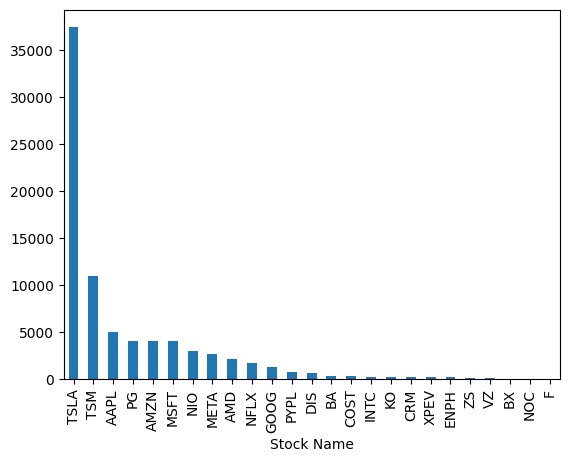

In [4]:
print(tweets_df["Stock Name"].nunique())
tweets_df["Stock Name"].value_counts().plot(kind="bar")

In [5]:
def clean_tweet(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove mentions (@username) and hashtags
    text = re.sub(r'@\w+|#', '', text)
    
    # Remove special characters, numbers, and punctuations
    text = re.sub(r'[^A-Za-z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

In [6]:
tweets_df["Tweet"] = tweets_df['Tweet'].apply(clean_tweet)

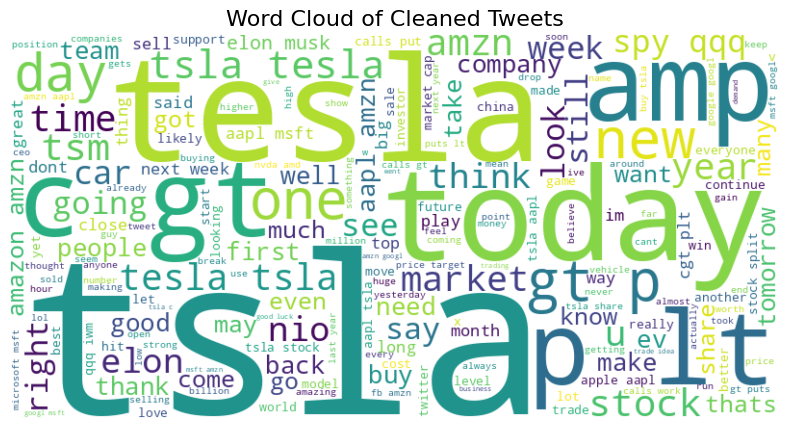

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all cleaned tweets into a single string
all_cleaned_tweets = ' '.join(tweets_df['Tweet'].dropna().tolist())

# Create the word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200, colormap='viridis').generate(all_cleaned_tweets)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Tweets', fontsize=16)
plt.show()

In [9]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load FinBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModel.from_pretrained("yiyanghkust/finbert-tone")

def get_finbert_embeddings(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    # Get the model's output embeddings
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract the embeddings from the last hidden layer
    last_hidden_states = outputs.last_hidden_state.squeeze(0)  # Shape: [sequence_length, hidden_size]
    
    # Aggregating the embeddings using mean pooling
    tweet_embedding = torch.mean(last_hidden_states, dim=0)  
    
    return tweet_embedding.numpy()

# Apply the function to each tweet to convert them into embeddings
tweets_df['finbert_embedding'] = tweets_df['Tweet'].apply(get_finbert_embeddings)

In [ ]:
tweets_df.head(5)

In [ ]:
tweets_df.to_csv("datasets/tweets_with_embeddings.csv", index=False)

## Stocks

In [20]:
stocks_df = pd.read_csv("datasets/stocks.csv")

In [21]:
stocks_df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [22]:
stocks_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6300.000000,6300.000000,6300.000000,6300.000000,6300.000000,6.300000e+03
mean,174.748195,177.594589,171.734715,174.657624,173.756012,2.906806e+07
std,134.989675,136.795419,133.049955,134.949601,134.582934,3.342181e+07
min,11.050000,11.210000,10.610000,11.060000,10.837500,3.078000e+05
25%,78.170002,79.891003,76.792501,78.110001,78.110001,5.857700e+06
50%,145.475128,147.475006,143.501251,145.505005,144.248146,1.518830e+07
75%,225.665001,230.662498,221.452496,225.785000,225.785000,4.122928e+07
max,692.349976,700.989990,686.090027,691.690002,691.690002,3.116452e+08


In [23]:
stocks_df["Stock Name"].nunique()

25

In [24]:
stocks_df.isna().sum()

Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Stock Name    0
dtype: int64

In [25]:
stocks_df.index = pd.to_datetime(stocks_df['Date'])
stocks_df.drop(columns=['Date'], inplace=True)
stocks_df.sort_index(inplace=True)
stocks_df.head(5)

,Open,High,Low,Close,Adj Close,Volume,Stock Name
Date,,,,,,,
2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
2021-09-30,285.709991,287.829987,281.619995,281.920013,278.792847,32343600,MSFT
2021-09-30,165.800003,166.392502,163.699493,164.251999,164.251999,56848000,AMZN
2021-09-30,150.190002,151.729996,148.000000,149.970001,149.970001,1904500,ENPH
2021-09-30,260.410004,263.519989,258.299988,262.220001,262.220001,1355300,ZS


In [26]:
def plot_all_stocks_moving_averages(stock_df, column_name='Close', short_window=7, long_window=30, stocks_per_row=5):

    stock_names = stock_df['Stock Name'].unique()
    total_stocks = len(stock_names)
    
    # Calculate the number of rows needed
    num_rows = (total_stocks // stocks_per_row) + (total_stocks % stocks_per_row > 0)
    
    # Set up the figure for subplots
    plt.figure(figsize=(stocks_per_row * 5, num_rows * 4))
    
    for idx, stock_name in enumerate(stock_names):
        # Create a subplot for each stock
        plt.subplot(num_rows, stocks_per_row, idx + 1)
        
        # Filter the data for the specific stock
        stock_data = stock_df[stock_df['Stock Name'] == stock_name].copy()
                
        # Calculate moving averages
        stock_data['Short_MA'] = stock_data[column_name].rolling(window=short_window, min_periods=1).mean()
        stock_data['Long_MA'] = stock_data[column_name].rolling(window=long_window, min_periods=1).mean()
        
        # Plot the actual values and moving averages
        plt.plot(stock_data.index, stock_data[column_name], label=f'{stock_name}', color='blue', alpha=0.5)
        plt.plot(stock_data.index, stock_data['Short_MA'], label=f'{short_window}-Day MA', color='green', linestyle='--')
        plt.plot(stock_data.index, stock_data['Long_MA'], label=f'{long_window}-Day MA', color='red', linestyle='--')
        
        # Adding title and labels
        plt.title(f'{stock_name}', fontsize=10)
        plt.xlabel('Date', fontsize=8)
        plt.ylabel(column_name, fontsize=8)
        plt.legend(fontsize=6)
        plt.grid(True)
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

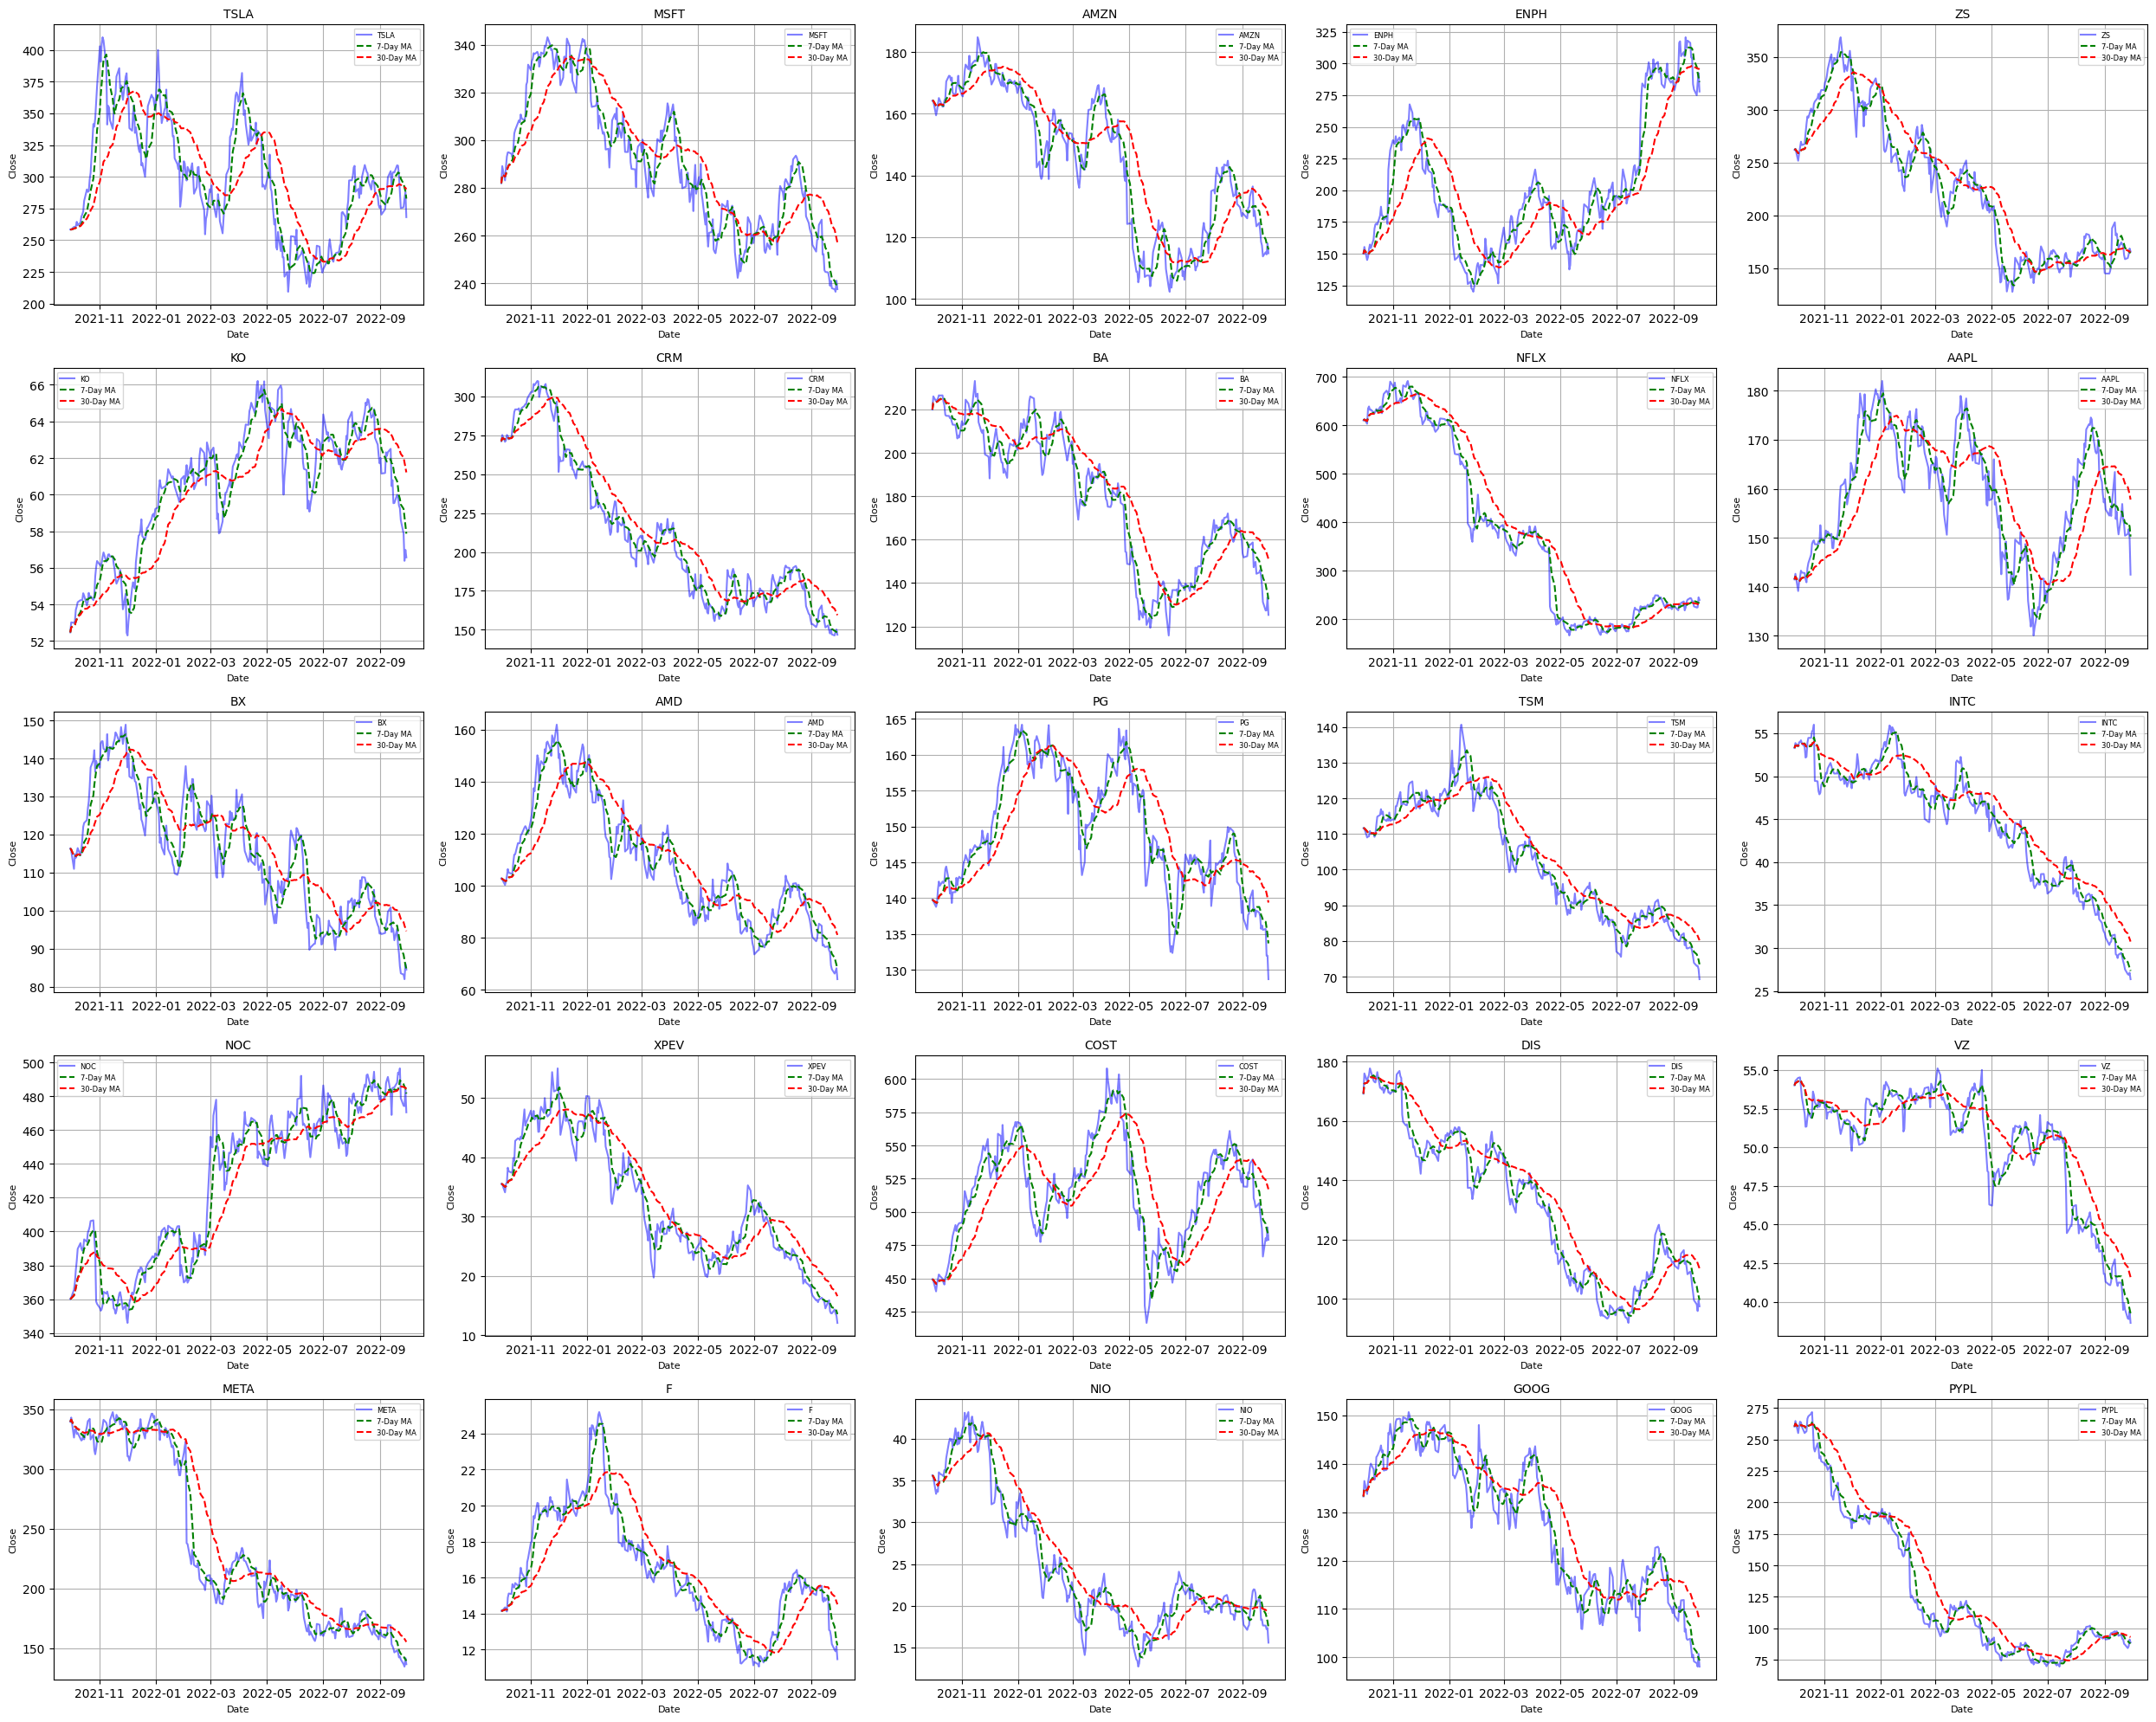

In [27]:
plot_all_stocks_moving_averages(stocks_df, column_name='Close', short_window=7, long_window=30, stocks_per_row=5)

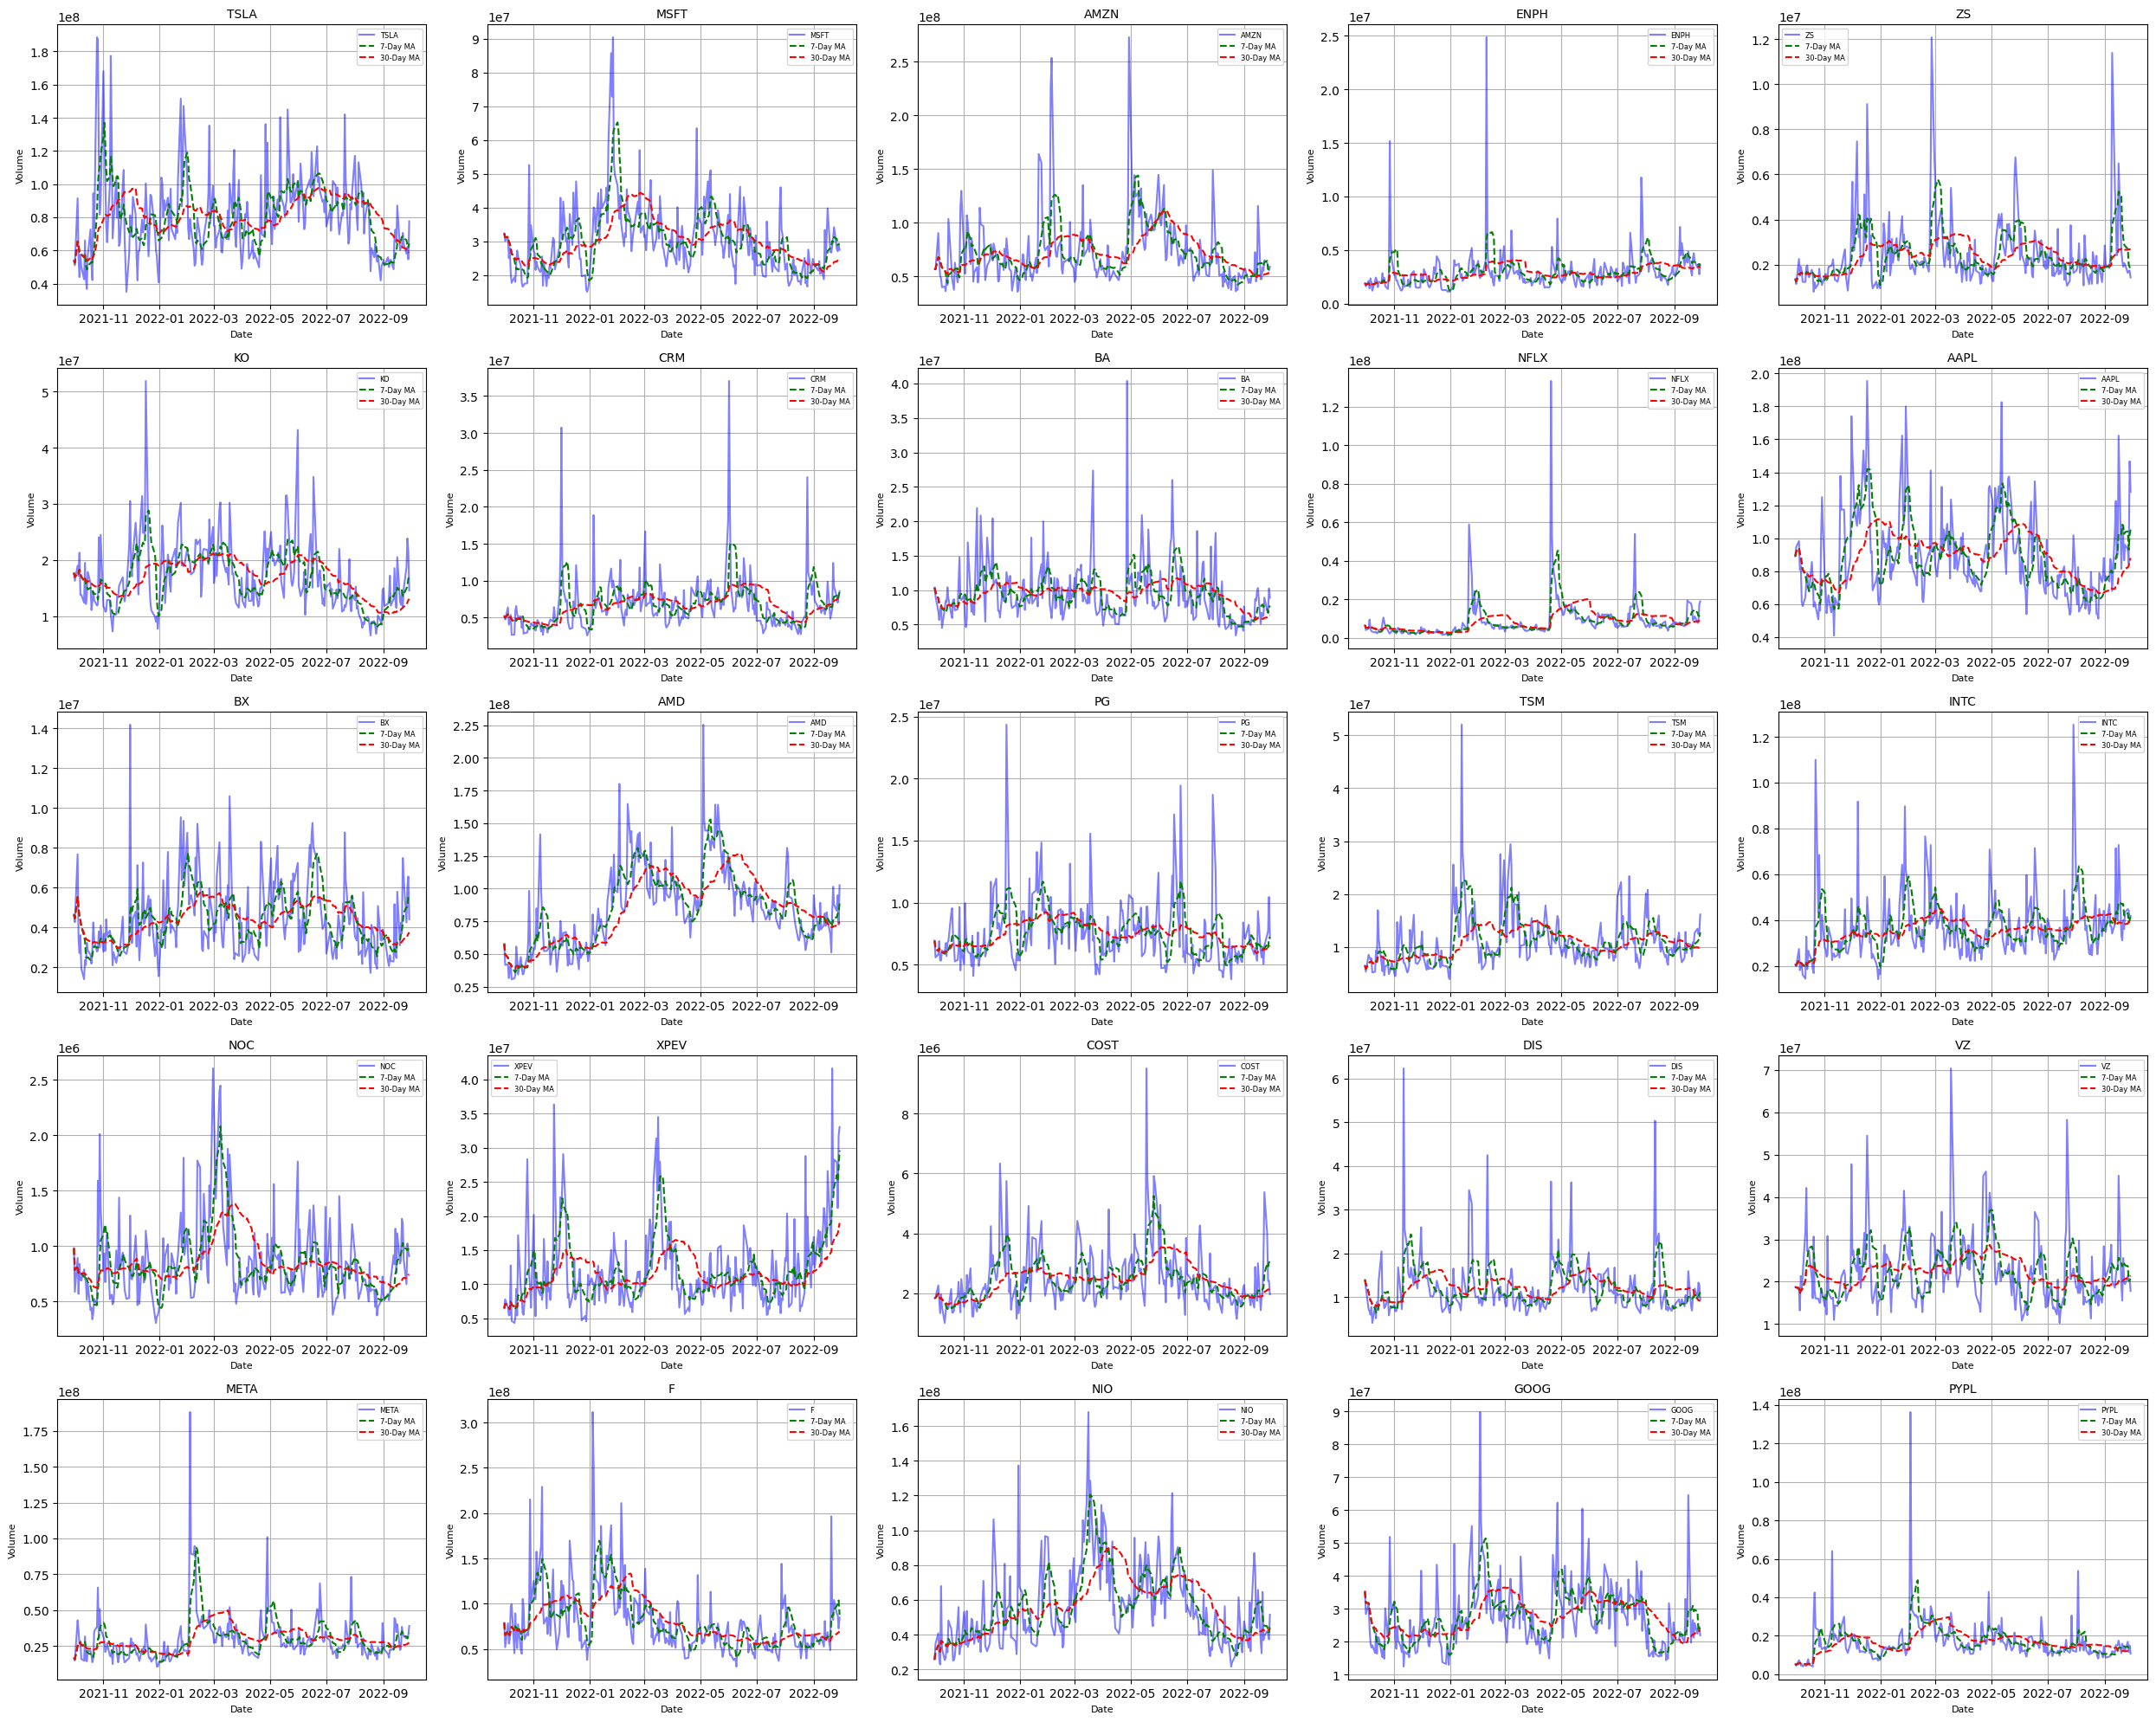

In [28]:
plot_all_stocks_moving_averages(stocks_df, column_name='Volume', short_window=7, long_window=30, stocks_per_row=5)

In [29]:
from sklearn.preprocessing import StandardScaler    
scaler = StandardScaler()
scaler.fit(stocks_df[["Open", "High", "Low", 'Close',"Adj Close", 'Volume']])
stocks_df[["Open", "High", "Low", 'Close',"Adj Close", 'Volume']] = scaler.transform(stocks_df[["Open", "High", "Low", 'Close',"Adj Close", 'Volume']])
stocks_df = pd.get_dummies(stocks_df, columns=['Stock Name'], prefix='', prefix_sep='')
stocks_df.head(5)

,Open,High,Low,Close,Adj Close,Volume,AAPL,AMD,AMZN,BA,...,NFLX,NIO,NOC,PG,PYPL,TSLA,TSM,VZ,XPEV,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-30,0.634063,0.624696,0.650925,0.621287,0.629679,0.742088,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2021-09-30,0.822067,0.805905,0.825960,0.794896,0.780524,0.098014,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2021-09-30,-0.066293,-0.081896,-0.060397,-0.077114,-0.070624,0.831258,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2021-09-30,-0.181941,-0.189090,-0.178404,-0.182954,-0.176753,-0.812814,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2021-09-30,0.634631,0.628181,0.650674,0.648904,0.657372,-0.829248,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


## Merge both DataFrames